In [18]:
from collections import defaultdict
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate


In [19]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
ROWS_TO_PREDICT = 32
# one day 16 rows of data

In [20]:
df = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0
...,...,...,...,...,...,...
2021-02-09 11:30:00-05:00,270.421387,271.299988,269.619995,270.750000,270.750000,1494395
2021-02-09 12:30:00-05:00,270.813995,270.950012,269.299988,269.399994,269.399994,911869
2021-02-09 13:30:00-05:00,269.429993,270.890015,269.359985,270.022491,270.022491,1019113


In [21]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.2:
        return 1
    if row['close_shift'] -row['close']< -1.2:
        return -1
    else:
        return 0


def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [22]:
df.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
df.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-02-10 04:00:00-05:00,212.250000,212.610000,212.200000,212.200000,212.200000,0
2020-02-10 06:00:00-05:00,212.080000,212.610000,212.080000,212.300000,212.300000,0
2020-02-10 07:00:00-05:00,212.030000,212.400000,212.030000,212.310000,212.310000,0
2020-02-10 08:00:00-05:00,212.280000,212.400000,212.010100,212.101200,212.101200,0
2020-02-10 09:00:00-05:00,212.200000,212.200000,211.500000,211.540000,211.540000,0
2020-02-10 09:30:00-05:00,211.520004,213.800003,210.914505,213.279999,213.279999,2938100
2020-02-10 10:30:00-05:00,213.279999,213.779999,212.199997,212.500000,212.500000,1377017
2020-02-10 11:30:00-05:00,212.490204,212.628998,211.800003,212.050003,212.050003,1034574
2020-02-10 12:30:00-05:00,212.041107,212.619995,211.850006,212.360001,212.360001,664739


<AxesSubplot:xlabel='Datetime'>

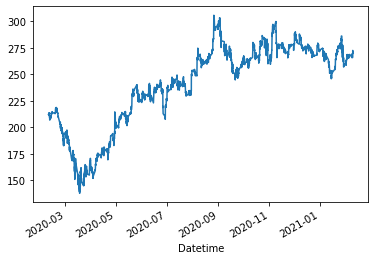

In [23]:
df['close'].plot()

In [24]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    # data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    # data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

In [25]:
score = defaultdict(list)
for window in range(1,21):
    data = df.copy()
    data = _get_indicator_data(data)

    data['close_shift'] = data.shift(-window)['close']
    data['class_column'] = data.apply(create_class_column, axis=1)
    # Class divide
    print(data['class_column'].value_counts())


    del (data['close'])
    del (data['close_shift'])
    data = data.dropna()
    train_set = data.iloc[:-ROWS_TO_PREDICT]
    test_set =data.iloc[-ROWS_TO_PREDICT:]

    y = data['class_column']
    features = [x for x in data.columns if x not in ['class_column']]
    x = data[features]

    x_train, x_test, y_train, y_test  = train_test_split(x,y,test_size=0.2,shuffle=False)

    classifiers = dict()

    classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
    classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
    classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
    classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
    classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
    classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
    classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
    classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')

    classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
    classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
    classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
    classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini')
    classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy')
    classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
    classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
    classifiers['RandomForestClassifier 8'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='entropy')

    classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
    classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
    classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
    classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
    #
    classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
    classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
    classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
    classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)

    classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
    classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
    classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
    classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

    predictions= dict()
    for k,v in classifiers.items():
        print("Calculate: ", k)
        train_model(v,x_train,y_train)
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        # print('Score: ',  score[k] )
        # print_conf_matrix(test_y, predictions[k], k)




 0    3003
 1     571
-1     568
Name: class_column, dtype: int64
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  DecisionTreeClassifier 3
Calculate:  DecisionTreeClassifier 4
Calculate:  DecisionTreeClassifier 5
Calculate:  DecisionTreeClassifier 6
Calculate:  DecisionTreeClassifier 7
Calculate:  DecisionTreeClassifier 8
Calculate:  RandomForestClassifier 1
Calculate:  RandomForestClassifier 2
Calculate:  RandomForestClassifier 3
Calculate:  RandomForestClassifier 4
Calculate:  RandomForestClassifier 5
Calculate:  RandomForestClassifier 6
Calculate:  RandomForestClassifier 7
Calculate:  RandomForestClassifier 8
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  GradientBoostingClassifier 3
Calculate:  GradientBoostingClassifier 4
Calculate:  GradientBoostingClassifier 5
Calculate:  GradientBoostingClassifier 6
Calculate:  GradientBoostingClassifier 7
Calculate:  GradientBoostingClassifier 8
Calculate:  Gr

In [35]:
headers = ["Classifier type", "Accuracy"]
new_headers = [f'Accuracy window {i}' for i in range(1,21)]
headers2 = ["Classifier type",] + new_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index= score_df.index, columns=new_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
print(tabulate(f_out, headers2, tablefmt="psql"))

+----+-------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|    | Classifier type               |   Accuracy window 1 |   Accuracy window 2 |   Accuracy window 3 |   Accuracy window 4 |   Accuracy window 5 |   Accuracy window 6 |   Accuracy window 7 |   Accuracy window 8 |   Accuracy window 9 |   Accuracy window 10 |   Accuracy window 11 |   Accuracy window 12 |   Accuracy window 13 |   Accuracy window 14 |   Accuracy window 15 |   Accuracy window 16 |   Accuracy window 17 |   Accuracy window 18 |   Accuracy window 19 |   Accuracy window 20 |
|----+--------------